<a href="https://colab.research.google.com/github/anvelezec/hans_on_colab/blob/master/AMPs_data_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data base consolidation
There are plenty of antimicrobial peptides (AMPs) databases on the web, some useful links that centralize universities, research groups or laboratories metadata to download them are:
* http://crdd.osdd.net/raghava/satpdb/links.php
* http://www.uwm.edu.pl/biochemia/index.php/en/biopep/32-bioactive-peptide-databases
 
Sometimes the discovered AMPs are able to be downloaded in a fasta, csv or txt format. In other occasions we should use web scraping to consolidate peptides and its properties.
 
During this notebook we are going to focus on the data pipeline creation, and we are using a database of 12794 AMPs previously constructed.

# Peptide generation data pipeline

In [1]:
!pip install -q tfds-nightly

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Load AMPs dataset
Since we would not load all our dataset in memory we use tf.data.TextLineDataset to read batches of AMPs and feed them into a model. This way we could scale our computing capacity at different dataset sizes.

In [3]:
peptide_tld = tf.data.TextLineDataset("/content/peptides_2020.txt")

In [4]:
unique_peptides = set()
max_length = 0
min_length = 100
for peptide in peptide_tld.take(-1):
  peptide = peptide.numpy()
  max_length = max(max_length, len(peptide))
  min_length = min(min_length, len(peptide))
  unique_peptides.add(peptide)

print("Number of unique AMPs {}.".format(str(len(unique_peptides))))
print("Min AMPs length {}.".format(str(min_length)))
print("Max AMPs length {}.".format(str(max_length)))

Number of unique AMPs 12794.
Min AMPs length 6.
Max AMPs length 299.


## Basic EDA
The AMPs length distribution ranges from 13-26 (percentiles 25-75), there are AMPs with length > 50 but they are not so common. 
 
This helps us to know the importance to use padding by batch during or data pipeline and not to pad all AMPs sequences to max_length.



In [5]:
pd_amps = pd.DataFrame(unique_peptides, columns=["AMPs"])
pd_amps["len"] = pd_amps.AMPs.apply(lambda x: len(x))
pd_amps.len.describe()

count    12794.000000
mean        23.928091
std         22.561189
min          6.000000
25%         13.000000
50%         18.000000
75%         26.000000
max        299.000000
Name: len, dtype: float64

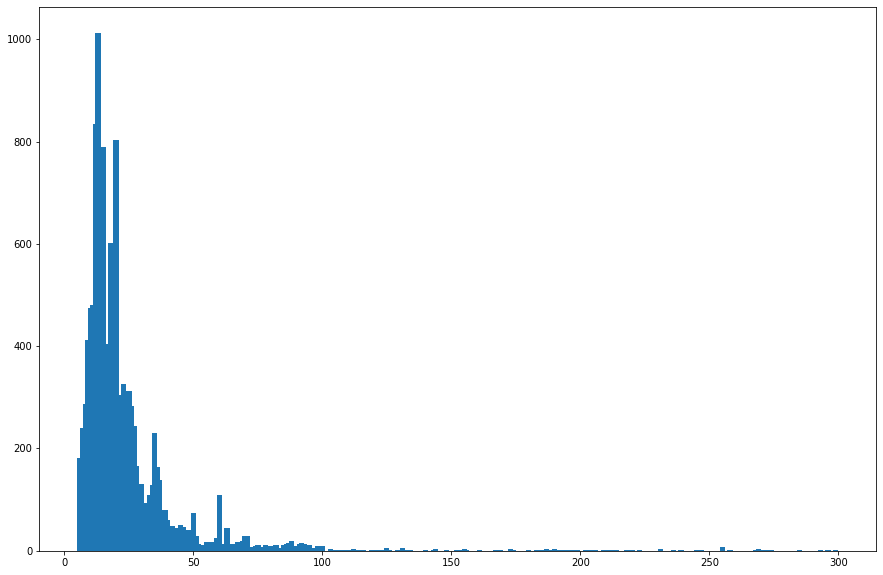

In [6]:
grouped_pd_amps = pd_amps.groupby("len").count()

plt.figure(figsize=(15,10))
plt.bar(grouped_pd_amps.index, 
        grouped_pd_amps.AMPs,
        width=2
        )

plt.show()

# Encode AMPs aminoacids as numbers

## Build vocabulary

Capture AMPs aminoacids

In [7]:
tokenizer = tfds.deprecated.text.Tokenizer()

In [8]:
tokenizer = tfds.deprecated.text.Tokenizer()
vocab_list = set()
for peptide in peptide_tld.take(-1):
  peptide = peptide.numpy()
  peptide = list(peptide.decode("utf-8"))
  vocab_list.update(peptide)

In [9]:
print("Number aminoacids {}".format(len(vocab_list)))
encoder = tfds.deprecated.text.TokenTextEncoder(vocab_list=vocab_list, decode_token_separator="")
vocab_list

Number aminoacids 19


{'A',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y'}

## encoder - decoder wrapper functions

Create encoder and decoder functions

In [10]:
def encode(peptide):
  peptide = peptide.numpy()
  peptide = " ".join(list(peptide.decode("utf-8")))
  encoded_peptide = encoder.encode(peptide)
  return [encoded_peptide]

def decode(encoded_peptide):
  peptide = encoder.decode(encoded_peptide)
  return peptide

In [11]:
for peptide in peptide_tld.take(5):
  print(peptide.numpy())
  encoded_peptide = encode(peptide=peptide)
  print(encoded_peptide)
  decoded_peptide = decode(encoded_peptide=encoded_peptide[0])
  print(decoded_peptide)
  print("\n")

b'MPKTRRRPRRSQRKRPPTPWPYGRKKRRQRRR'
[[14, 1, 2, 13, 3, 3, 3, 1, 3, 3, 19, 11, 3, 2, 3, 1, 1, 13, 1, 15, 1, 10, 8, 3, 2, 2, 3, 3, 11, 3, 3, 3]]
MPKTRRRPRRSQRKRPPTPWPYGRKKRRQRRR


b'KLWKLWLKWLL'
[[2, 17, 15, 2, 17, 15, 17, 2, 15, 17, 17]]
KLWKLWLKWLL


b'GINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYE'
[[8, 12, 16, 7, 19, 18, 18, 16, 12, 11, 2, 9, 12, 6, 3, 17, 16, 9, 18, 7, 2, 16, 17, 16, 9, 19, 17, 12, 6, 17, 11, 9, 17, 8, 2, 10, 9]]
GINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYE


b'IKELLPHLSGIIDSVANAIK'
[[12, 2, 9, 17, 17, 1, 4, 17, 19, 8, 12, 12, 6, 19, 18, 7, 16, 7, 12, 2]]
IKELLPHLSGIIDSVANAIK


b'FLPLIGKVLSSIL'
[[5, 17, 1, 17, 12, 8, 2, 18, 17, 19, 19, 12, 17]]
FLPLIGKVLSSIL




## Create encode-decode wrapper tf.py_function
Create a tf.py_function wrapper So you can .map this function directly. The tf.py_function will pass regular tensors (with a value and a .numpy() method to access it), to the wrapped python function.
You want to use Dataset.map to apply this function to each element of the dataset. Dataset.map runs in graph mode.

  * Graph tensors do not have a value.
  * In graph mode you can only use TensorFlow Ops and functions.


In [12]:
def encode_map_fn(peptide):
  # py_func doesn't set the shape of the returned tensors.
  encoded_peptide = tf.py_function(encode,
                                inp=[peptide], 
                                Tout=(tf.int64))
  
  # `tf.data.Datasets` work best if all components have a shape set
  #  so set the shapes manually: 
  encoded_peptide.set_shape([None])
  return encoded_peptide

## Final dataset pipeline
At this point we compare two pipeline variations.
  1. Shuffle dataset with buffer size, apply aminoacid to number encoder, take batch and pad it.
  2. Apply aminoacid to number encoder, Shuffle dataset with buffer size, take batch and pad it.

After comparing this to ways to create the pipeline we observe is faster to use option 1 since taking one batch takes aprox 34.1 ms compared with option 2 which takes aprox 1.56 seg.

With this we finish out the process to create a dataset pipeline with AMPs and we are ready to use at modelation stage.

In [13]:
BUFFER_SIZE = 6000
BATCH_SIZE = 64
TAKE_SIZE = 500

In [14]:
encoded_peptide_tld_1 = peptide_tld.shuffle(BUFFER_SIZE).map(encode_map_fn).padded_batch(BATCH_SIZE)
encoded_peptide_tld_2 = peptide_tld.map(encode_map_fn).shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)

In [15]:
def take(pipeline, n_take):
  for encoded_peptide in pipeline.take(n_take):
    print(encoded_peptide)
    print("\n")

In [16]:
%timeit take(encoded_peptide_tld_1, 1)

tf.Tensor(
[[ 8 17 17 ...  0  0  0]
 [ 8 17 17 ...  0  0  0]
 [ 2 15  2 ...  0  0  0]
 ...
 [ 2  2 15 ...  0  0  0]
 [ 2  2 15 ...  0  0  0]
 [ 8  3  3 ...  0  0  0]], shape=(64, 67), dtype=int64)


tf.Tensor(
[[ 8 12  8 ...  0  0  0]
 [ 8 17  2 ...  0  0  0]
 [14  2  2 ...  0  0  0]
 ...
 [ 6  6  7 ...  0  0  0]
 [ 2  2 15 ...  0  0  0]
 [14 19  3 ...  0  0  0]], shape=(64, 103), dtype=int64)


tf.Tensor(
[[ 8 14 15 ...  0  0  0]
 [17 17  8 ...  0  0  0]
 [13  5  5 ...  0  0  0]
 ...
 [ 5 12  4 ...  0  0  0]
 [ 3  3  2 ...  0  0  0]
 [ 7  3 17 ...  3  4 14]], shape=(64, 75), dtype=int64)


tf.Tensor(
[[17 17  1 ...  0  0  0]
 [ 8 17 17 ...  0  0  0]
 [15  2  2 ...  0  0  0]
 ...
 [ 3  5  3 ...  0  0  0]
 [ 8 17  2 ...  0  0  0]
 [ 7 18  8 ...  0  0  0]], shape=(64, 152), dtype=int64)


tf.Tensor(
[[19  1  3 ...  0  0  0]
 [17  2 17 ...  0  0  0]
 [15 12 11 ...  0  0  0]
 ...
 [ 2 17  2 ...  0  0  0]
 [ 5  1  9 ...  0  0  0]
 [ 1  8 13 ...  0  0  0]], shape=(64, 120), dtype=int64)


tf

In [17]:
%timeit take(encoded_peptide_tld_2, 2)

tf.Tensor(
[[12  7  7 ...  0  0  0]
 [ 2 16 15 ...  0  0  0]
 [19 15 19 ...  0  0  0]
 ...
 [ 8 17  5 ...  0  0  0]
 [ 3  3  3 ...  0  0  0]
 [ 3  5  3 ...  0  0  0]], shape=(64, 110), dtype=int64)


tf.Tensor(
[[14  2 15 ...  0  0  0]
 [12 17  1 ...  0  0  0]
 [ 8  5  2 ...  0  0  0]
 ...
 [ 2  2  3 ...  0  0  0]
 [ 3  1  1 ...  0  0  0]
 [12 16 15 ...  0  0  0]], shape=(64, 167), dtype=int64)


tf.Tensor(
[[ 2  2  2 ...  0  0  0]
 [19 15 17 ...  0  0  0]
 [12 16 15 ...  0  0  0]
 ...
 [ 5  7  2 ...  0  0  0]
 [12 12 16 ...  0  0  0]
 [ 8 12  8 ...  0  0  0]], shape=(64, 120), dtype=int64)


tf.Tensor(
[[ 8 17  8 ...  0  0  0]
 [14 19  7 ...  0  0  0]
 [ 7  6  1 ...  0  0  0]
 ...
 [ 2 12 16 ...  0  0  0]
 [ 1  2 12 ...  0  0  0]
 [ 8  9 17 ...  0  0  0]], shape=(64, 70), dtype=int64)


tf.Tensor(
[[ 3  1  1 ...  0  0  0]
 [15  2  3 ...  0  0  0]
 [14  1  2 ...  0  0  0]
 ...
 [12  2 11 ...  0  0  0]
 [ 8 17  3 ...  0  0  0]
 [ 2  2 17 ...  0  0  0]], shape=(64, 98), dtype=int64)


tf